In [14]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib.pyplot import rc_context

sc.settings.verbosity = 1
sc.logging.print_header()
sns.set_context( "paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
sys.path.insert(0, '../')
import new_misc_code as mc 

In [4]:
# set paths to directories for data and figures
data_path = "../data/"
fig_path = "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/out_figs/"

### Read in combined samples anndata object 

In [5]:
adata = sc.read( f"{data_path}combined_count_matrices.h5ad")
adata

AnnData object with n_obs × n_vars = 194703 × 32738
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot'
    var: 'gene_ids', 'feature_types', 'non-unique_names'
    uns: 'age_order', 'batch_order', 'stage_colors_dict', 'stage_id_colors', 'stage_order'

# **QC nuclei**

In [6]:
# get scanpy quality metrics
sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True);

In [7]:
# remove genes with fewer than 5 total counts
sc.pp.filter_genes( adata, min_counts=5, inplace=True)
adata.shape

(194703, 29131)

### Remove dublets with scrublet

In [8]:
# Remove doublets using scrublet on a per sample basis
import scrublet as scr

dub_mk = np.array( [False]*adata.shape[0], dtype=bool)
dub_sc = np.array( [False]*adata.shape[0], dtype=float)
for bat_itr in adata.uns['batch_order']:
    bat_mk    = adata.obs['batch'].values==bat_itr
    adata_itr = adata[bat_mk,:]
    scrub = scr.Scrublet( adata_itr.X.tocsc(), expected_doublet_rate=0.1)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( min_counts=2, 
                                                               min_cells=3, 
                                                               min_gene_variability_pctl=85, 
                                                               n_prin_comps=10,
                                                               verbose=False)
    dub_mk[bat_mk] = predicted_doublets
    dub_sc[bat_mk] = doublet_scores
    
print( "Number of potential dublet nucs found in each sample:")
sample_cts = pd.value_counts( adata.obs.batch[dub_mk])
print( sample_cts.to_string())
print( "Total doublets found = ", sample_cts.values.sum())

Number of potential dublet nucs found in each sample:
RL2121_ga34_v3    936
RL1777_2d_v3      673
RL2108_179d_v3    652
RL2107_ga24_v3    476
RL2106_6yr_v3     461
RL2100_86d_v3     407
RL2128_20yr_v3    385
RL2124_40yr_v3    293
RL2123_20yr_v3    286
RL1612_34d_v2     285
RL2131_17yr_v3    272
RL2102_16yr_v3    267
RL2126_10yr_v3    253
RL2109_4yr_v3     245
RL2127_12yr_v3    231
RL1614_8yr_v2     218
RL2132_25yr_v3    212
RL2105_627d_v3    193
RL2125_422d_v3    191
RL1613_2yr_v2     159
RL2122_301d_v3     82
RL2129_3yr_v3      65
RL2130_14yr_v3     49
RL1786_2yr_v3      44
RL2110_10yr_v3      7
RL2104_118d_v3      1
RL2103_ga22_v3      0
Total doublets found =  7343


In [9]:
# add scrublet doublet scores to adata
adata.obs['doublet_score'] = dub_sc
# remove predicted doublets
adata = adata[~dub_mk]
adata.shape

(187360, 29131)

In [10]:
sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True)

Trying to set attribute `.obs` of view, copying.


### Library sizes and feature counts per sample

In [11]:
# maximum number of colors in a colormap is tab20, since we have over 20 samples 
# generate randomly distinct colors for each batch-from functions in misc_code.py file
adata.uns['batch_colors'] = mc.random_hex_colors( n_colors=len( adata.uns['batch_order']), random_seed=0)
adata.uns['batch_colors_dict'] = dict( zip( adata.obs['batch'].cat.categories.tolist(), adata.uns['batch_colors']))
adata.uns['batch_colors']

array(['#c67751', '#16f2f8', '#0b1010', '#821ffc', '#53f318', '#f8fcc0',
       '#1f62a1', '#f718a0', '#87cb8e', '#ffd409', '#d09aff', '#7a0a5b',
       '#15ae43', '#ec2d0b', '#6e640a', '#559ed8', '#b157bf', '#150edb',
       '#c8fe43', '#26f87a', '#f6a289', '#9dfdf6', '#374443', '#5f836a',
       '#94b027', '#f141f4', '#3a54f9'], dtype='<U7')

In [12]:
adata.obs['log10_gene_counts'] = np.log10( adata.obs['n_genes_by_counts'])
adata.obs['log10_UMI_counts']  = np.log10( adata.obs['total_counts'])

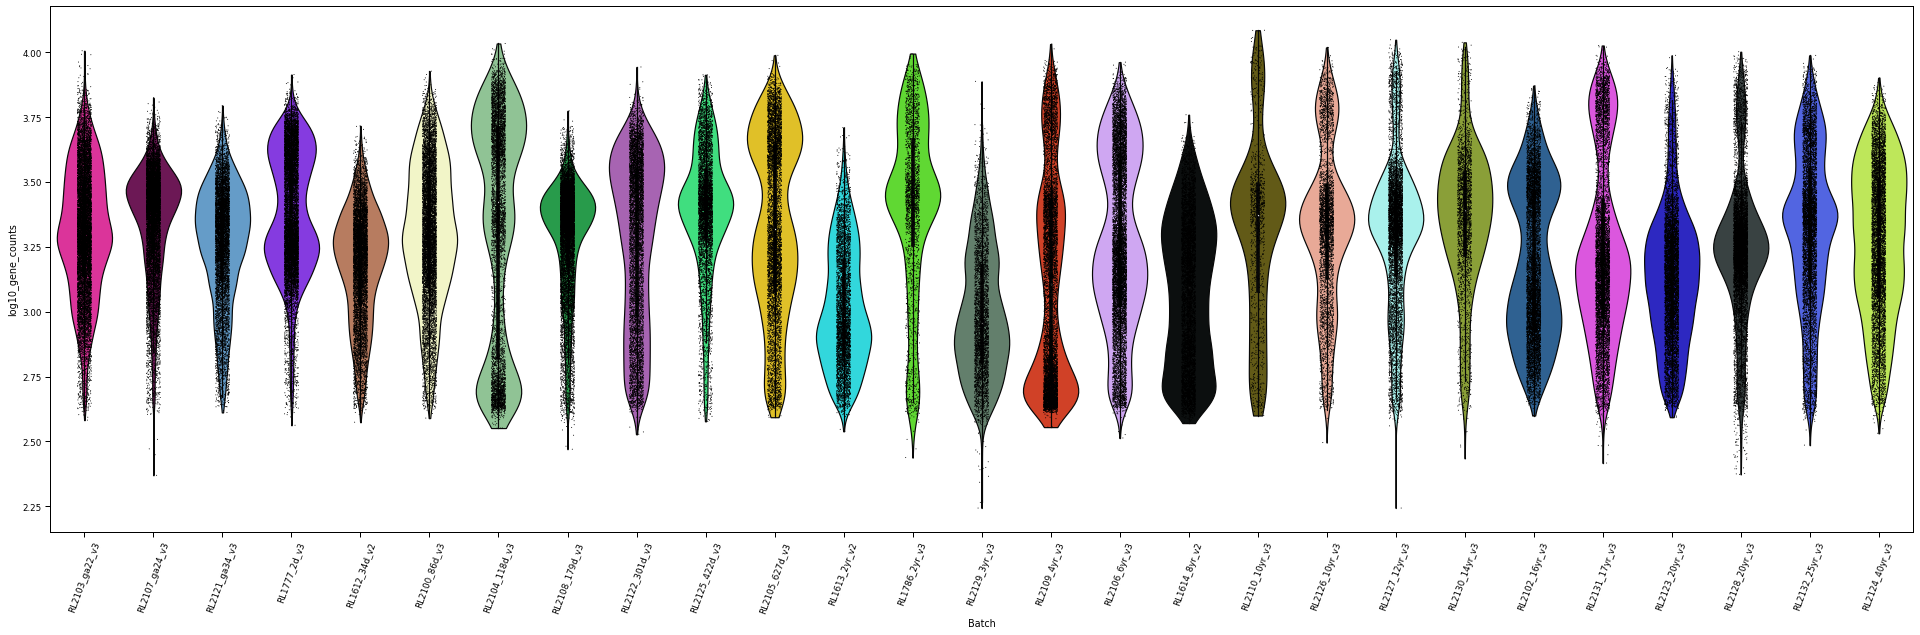

In [15]:
with rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin( adata, ['log10_gene_counts'], groupby='batch', stripplot=True, 
                  inner='box', order=adata.uns['batch_order'], rotation=70, xlabel='Batch', show=False)
    plt.savefig( f"{fig_path}violin_feature-cts.png", format='png', bbox_inches='tight')

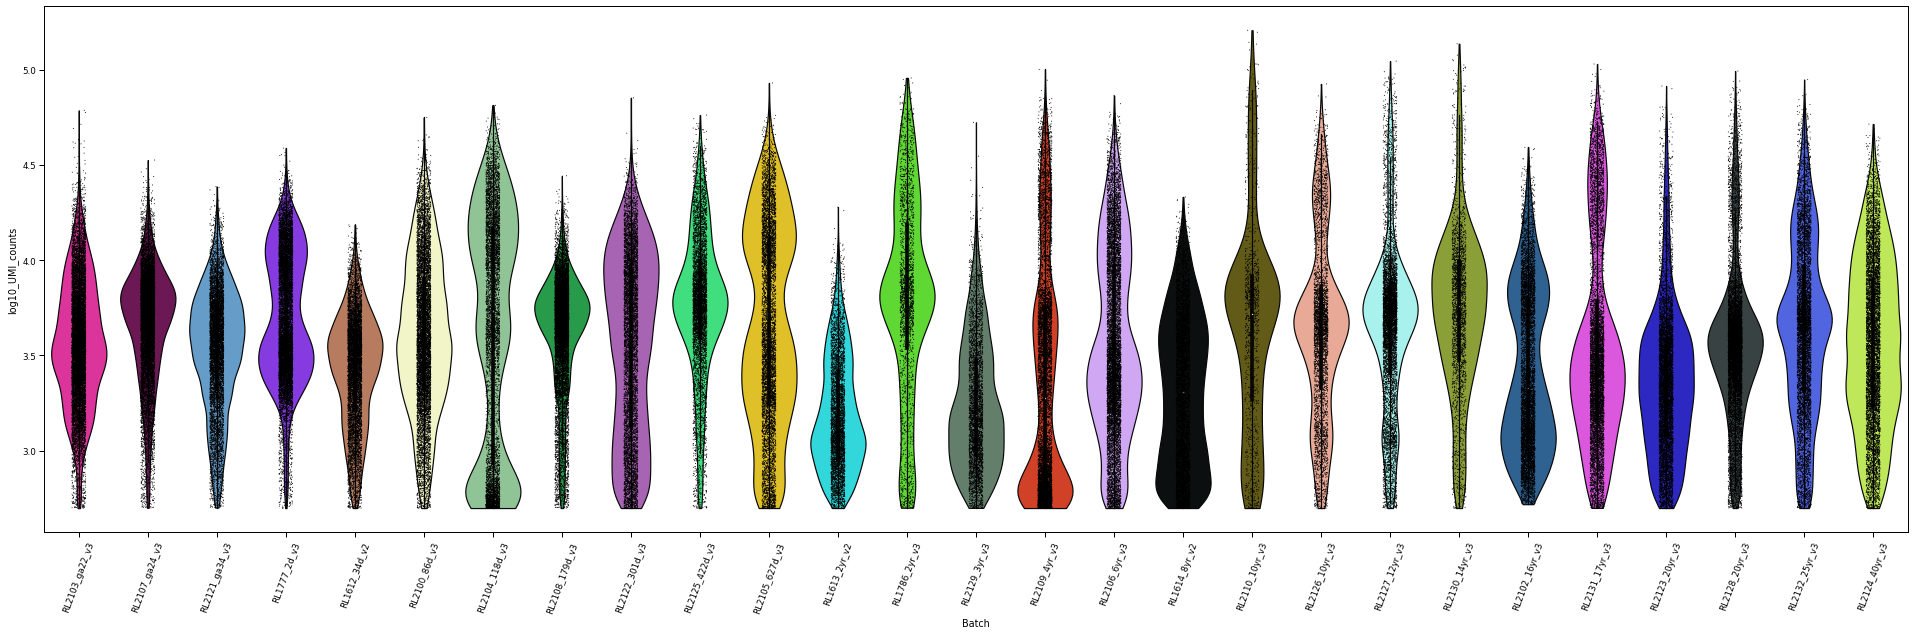

In [16]:
with rc_context({'figure.figsize': (25,10)}):
    ax = sc.pl.violin( adata, ['log10_UMI_counts'], groupby='batch', stripplot=True, 
                  inner='box', order=adata.uns['batch_order'], rotation=70, xlabel='Batch', show=False)
    plt.savefig( f"{fig_path}violin_library-sizes.png", format='png', bbox_inches='tight')

In [17]:
# Return adata with nuclei masked removed and print number removed from each batch
def mask_cells( adata, mask):
    sample_cts = pd.value_counts( adata.obs.batch[~mask])
    print( "Number of removed nuclei per sample:")
    print( sample_cts[sample_cts>0].to_string())
    print( "Total removed = ", sample_cts.values.sum())
    adata = adata[mask,:]
    return( adata)

In [18]:
import math
from scipy import stats

# plot log feature counts per nucs and return low nuc mask by median absolute deviation
# will return bool mask for nuc with less than 3 MADs of gene counts, but will not remove nuclei over 300 gene counts
def plot_mask_feature_per_nuc( adata, feature, max_th, xlab, mad_scale=3.0):
    # use scanpy's built QCs metrics
    sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True);
    # max threshold in log space
    max_th = np.log10( max_th)
    low_feat_mask = np.array( [False]*adata.shape[0], dtype=bool)
    # seaborn plot settings
    sns.set()
    sns.set_context( "paper")
#     palette = itertools.cycle( sns.color_palette( 'colorblind'))
    # subplot params
    n    = len( adata.uns['batch_order'])
    cols = round( math.sqrt( n))
    rows = math.ceil( n / cols)
    size = cols * rows
    fig, axes = plt.subplots( cols, rows, figsize=( 5*cols, 4*rows), sharex=True)
    # loop through each sample
    for itr, (bat_itr, ax) in enumerate( zip( adata.uns['batch_order'], axes.flatten())):
        bat_mk = adata.obs['batch'].values==bat_itr
        # get feature counts as calculated by scanpy
        bat_feats = np.log10( adata.obs[feature][bat_mk] )
        # calc median absolute deviation
        med_th = min( max_th, np.median( bat_feats) - stats.median_absolute_deviation( bat_feats, scale=mad_scale))
        low_feat_mask[bat_mk] = bat_feats<med_th
        # plot on new subplot for each histogram
        plt.sca(ax)
        sd = sns.distplot( bat_feats, color=adata.uns['batch_colors_dict'][bat_itr])
        x, y = sd.get_lines()[0].get_data()
        plt.title( bat_itr)
        plt.vlines( med_th, 0, max(y), linestyles='dashed')
        plt.ylabel( "Nuclei Count Density", fontsize=8)
        plt.xlabel( xlab, fontsize=8)
    # clear rest of graphs
    for ii in range( itr+1, size):
        ax = axes.flatten()[ii]
        ax.axis('off')
    return( low_feat_mask)

### Remove nuclei with low feature counts

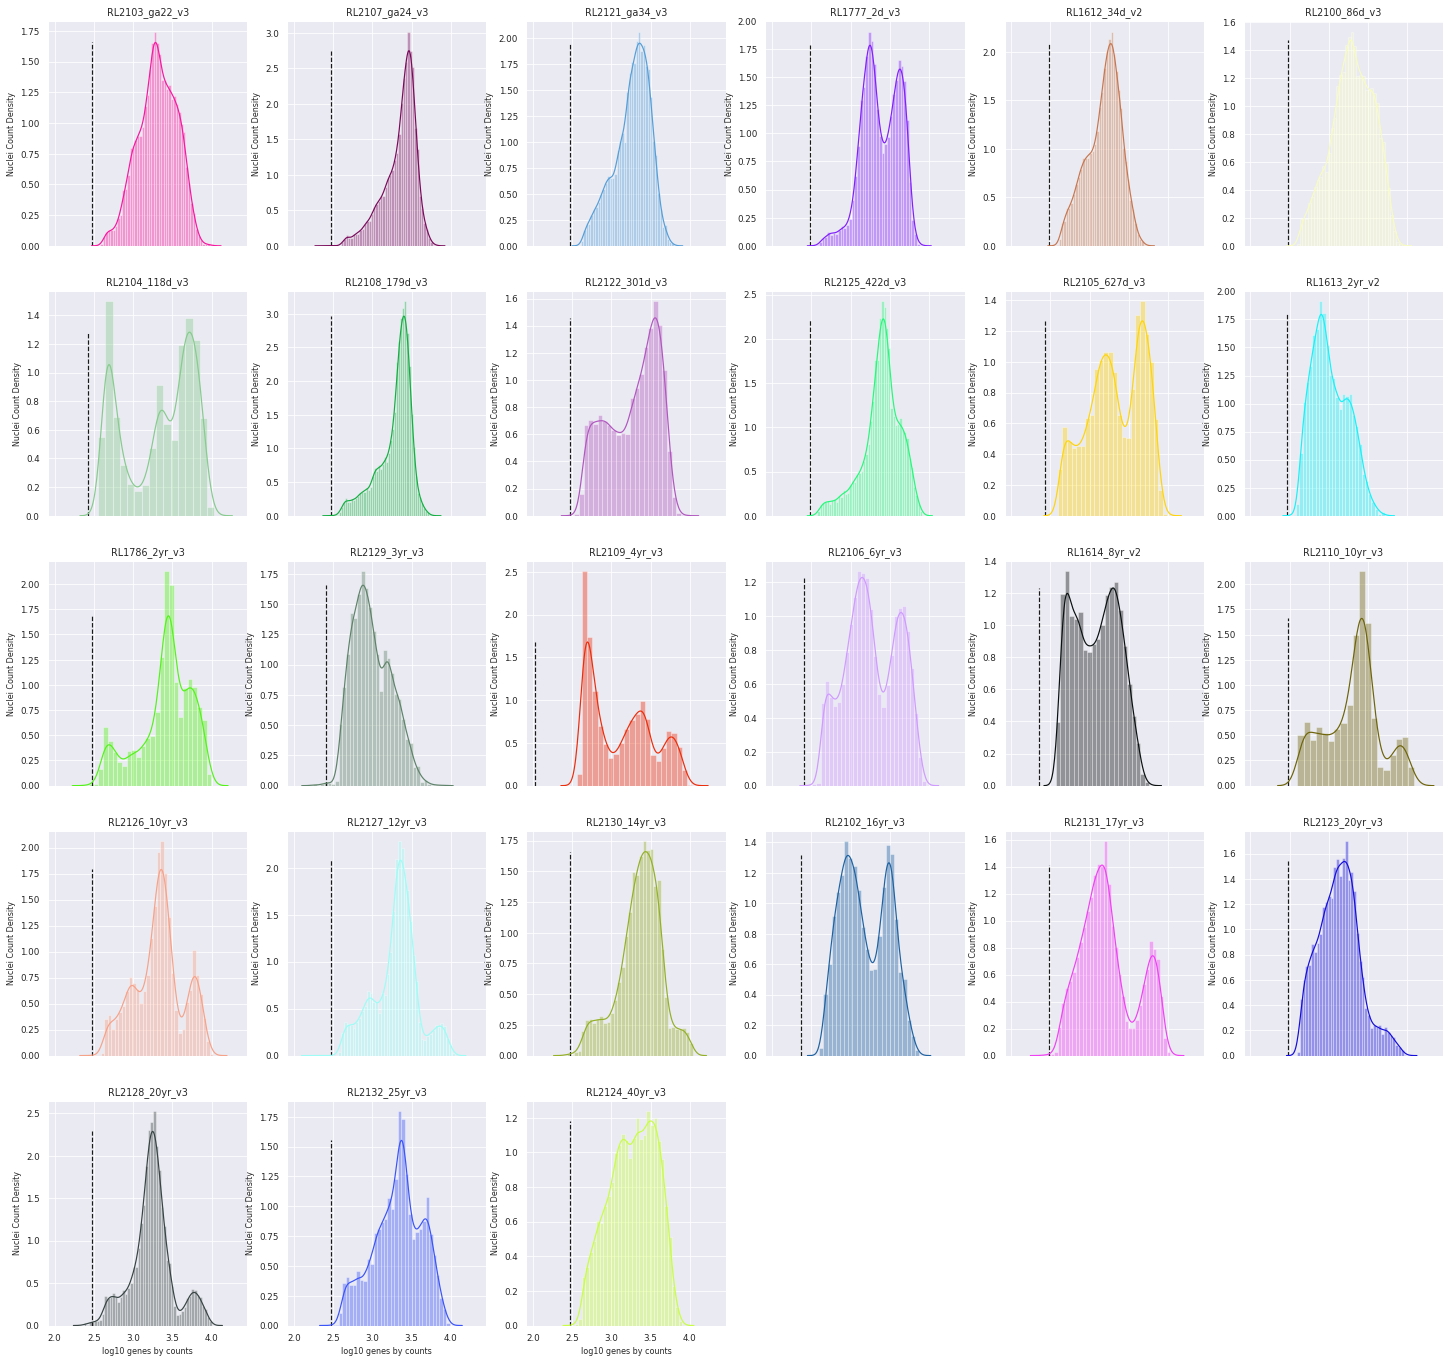

In [19]:
low_feat_mk = plot_mask_feature_per_nuc( adata, feature='n_genes_by_counts', 
                                            max_th=300,
                                            xlab="log10 genes by counts")

In [20]:
# remove cells with low features per cell
adata = mask_cells( adata, ~low_feat_mk)

Number of removed nuclei per sample:
RL2128_20yr_v3    23
RL2129_3yr_v3      8
RL2107_ga24_v3     3
RL2131_17yr_v3     2
RL1786_2yr_v3      2
RL2130_14yr_v3     1
RL2127_12yr_v3     1
RL2108_179d_v3     1
Total removed =  41


### Remove nuclei with high mitochondrial and ribosomal count percentages

We allow for changes in mito and ribo expression during maturation by removing on per sample basis rather than with a hard cutoff.

In [21]:
# plot gene set percentages and return high nuc mask by median absolute deviation
def gene_set_MAD_plot_and_mask( adata, gene_mask, max_per, log=True):
    # array to hold high mito per mask
    high_mk = np.array( [False]*adata.shape[0], dtype=bool)
    # seaborn settings for plot
    sns.set()
    sns.set_context( "paper")

    # subplot params
    n    = len( adata.uns['batch_order'])
    cols = round( math.sqrt( n))
    rows = math.ceil( n / cols)
    size = cols * rows
    fig, axes = plt.subplots( cols, rows, figsize=( 5*cols, 4*rows), sharex=True)
    # convert hard threshold if using logscale
    if( log==True):
        max_per = np.log10( max_per)
    # loop through each sample
    for itr, (bat_itr, ax) in enumerate( zip( adata.uns['batch_order'], axes.flatten())):
        bat_mk = adata.obs['batch'].values==bat_itr
        bat_adata = adata[bat_mk,:]
        # get sum of mito counts
        gene_mk_sum = np.asarray( bat_adata[:,gene_mask].X.sum(1)).reshape(-1)
        # get summed counts for each nuc over all genes
        lib_sizes = np.asarray( bat_adata.X.sum(1)).reshape(-1)
        # get percentage of library size for masked counts
        if( log==True):
            mk_per = np.log10( gene_mk_sum/lib_sizes.astype(float)*100 + 0.001)
        else:
            mk_per = gene_mk_sum/lib_sizes.astype(float)*100 + 0.001
        # calc median absolute deviation
        med_th = min( max_per, np.median( mk_per) + stats.median_absolute_deviation( mk_per, scale=3.0))
        high_mk[bat_mk] = mk_per>med_th
        # plot on new subplot for each histogram
        plt.sca(ax)
        sd = sns.distplot( mk_per, color=adata.uns['batch_colors_dict'][bat_itr])
        x, y = sd.get_lines()[0].get_data()
        plt.title( bat_itr)
        plt.vlines( med_th, 0, max(y), linestyles='dashed')
        plt.ylabel( "Nuclei Count Density", fontsize=8)
        if( log==True):
            plt.xlabel( "log10 percentages", fontsize=8)
        else:
            plt.xlabel( "percentages", fontsize=8)
    # clear rest of graphs
    for ii in range( itr+1, size):
        ax = axes.flatten()[ii]
        ax.axis('off')
    return( high_mk)

In [22]:
# pull all mito genes
mito_mk = adata.var_names.str.startswith('MT-')
mito_genes = adata.var_names.values[mito_mk]
# for each nuclei compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum( adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

Trying to set attribute `.obs` of view, copying.


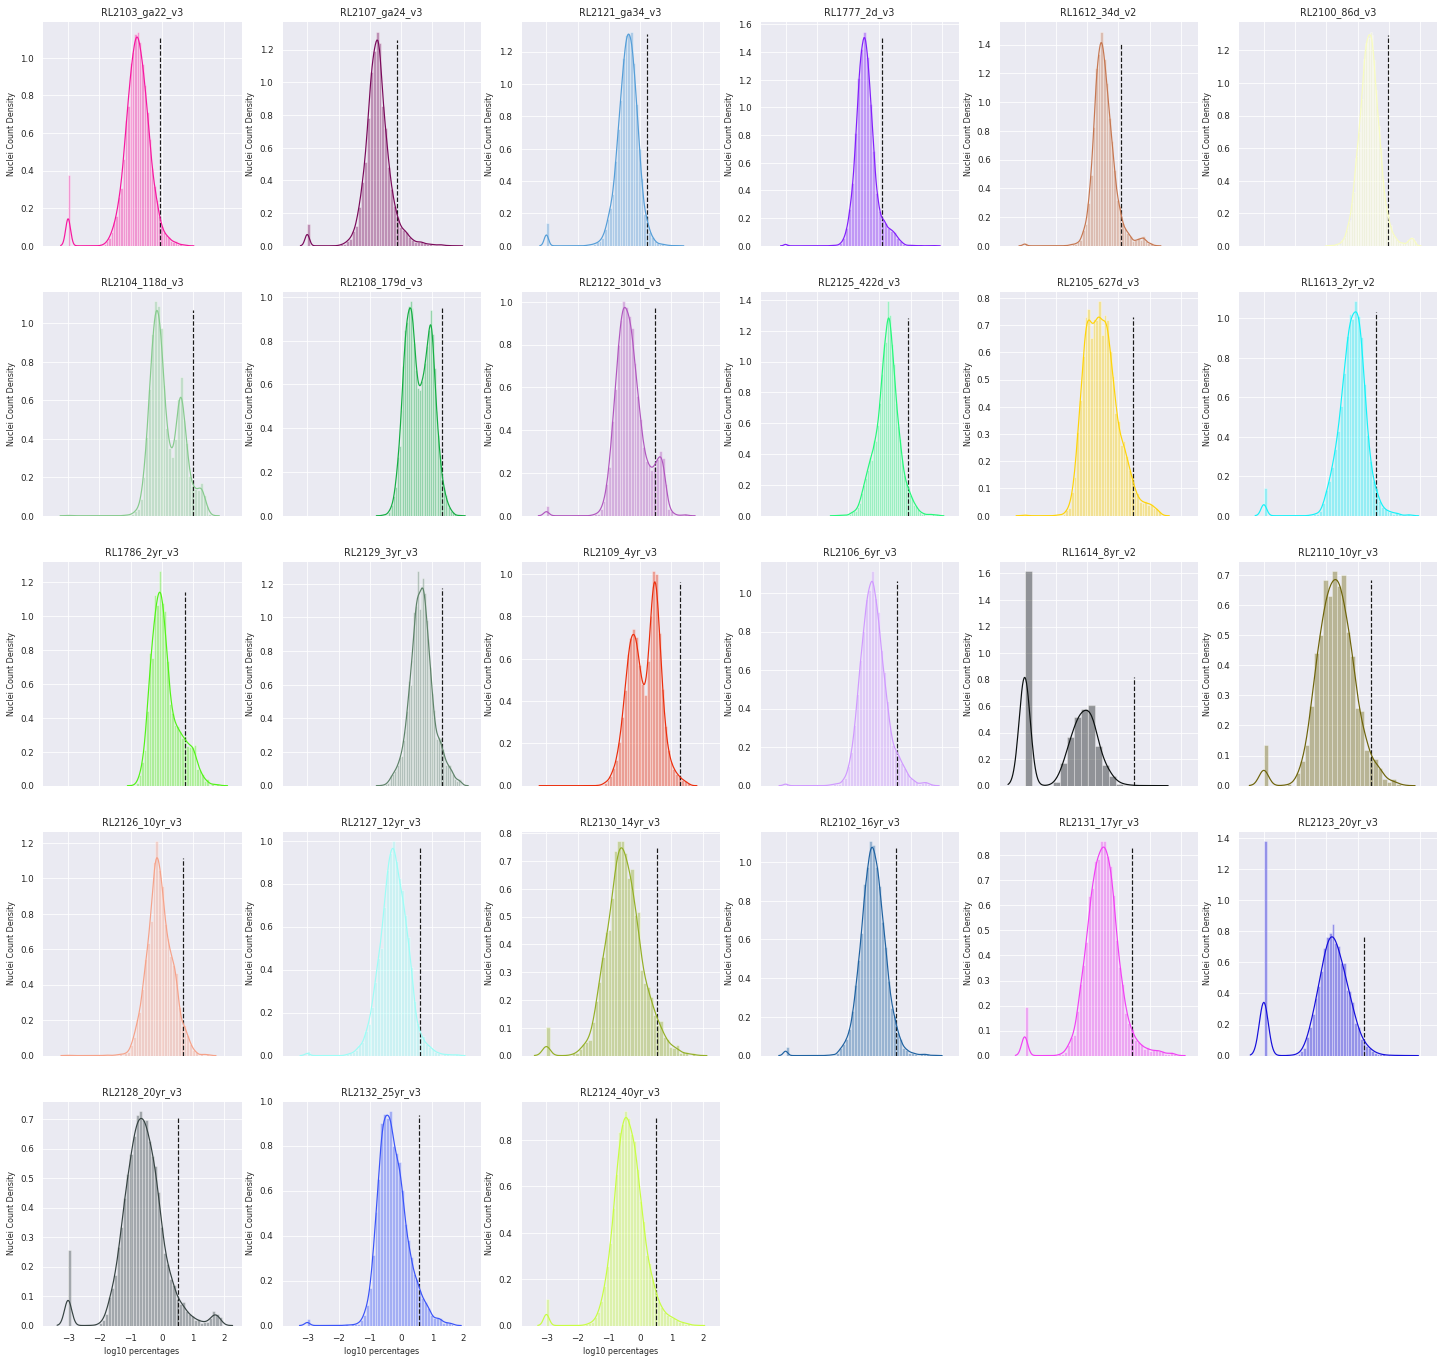

In [23]:
# remove all nuc with more than 3 MADs percentage mito gene counts
mito_per_mk = gene_set_MAD_plot_and_mask( adata, mito_mk, 20.0)

In [24]:
# read in list of ribo genes from kegg
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table( ribo_url, header=[1])
# create mask for all ribo genes
ribo_mk = np.in1d( adata.var_names.values.astype(str), ribo_genes)
adata.obs['percent_ribo'] = np.sum( adata[:,ribo_mk].X, axis=1).A1 / np.sum( adata.X, axis=1).A1

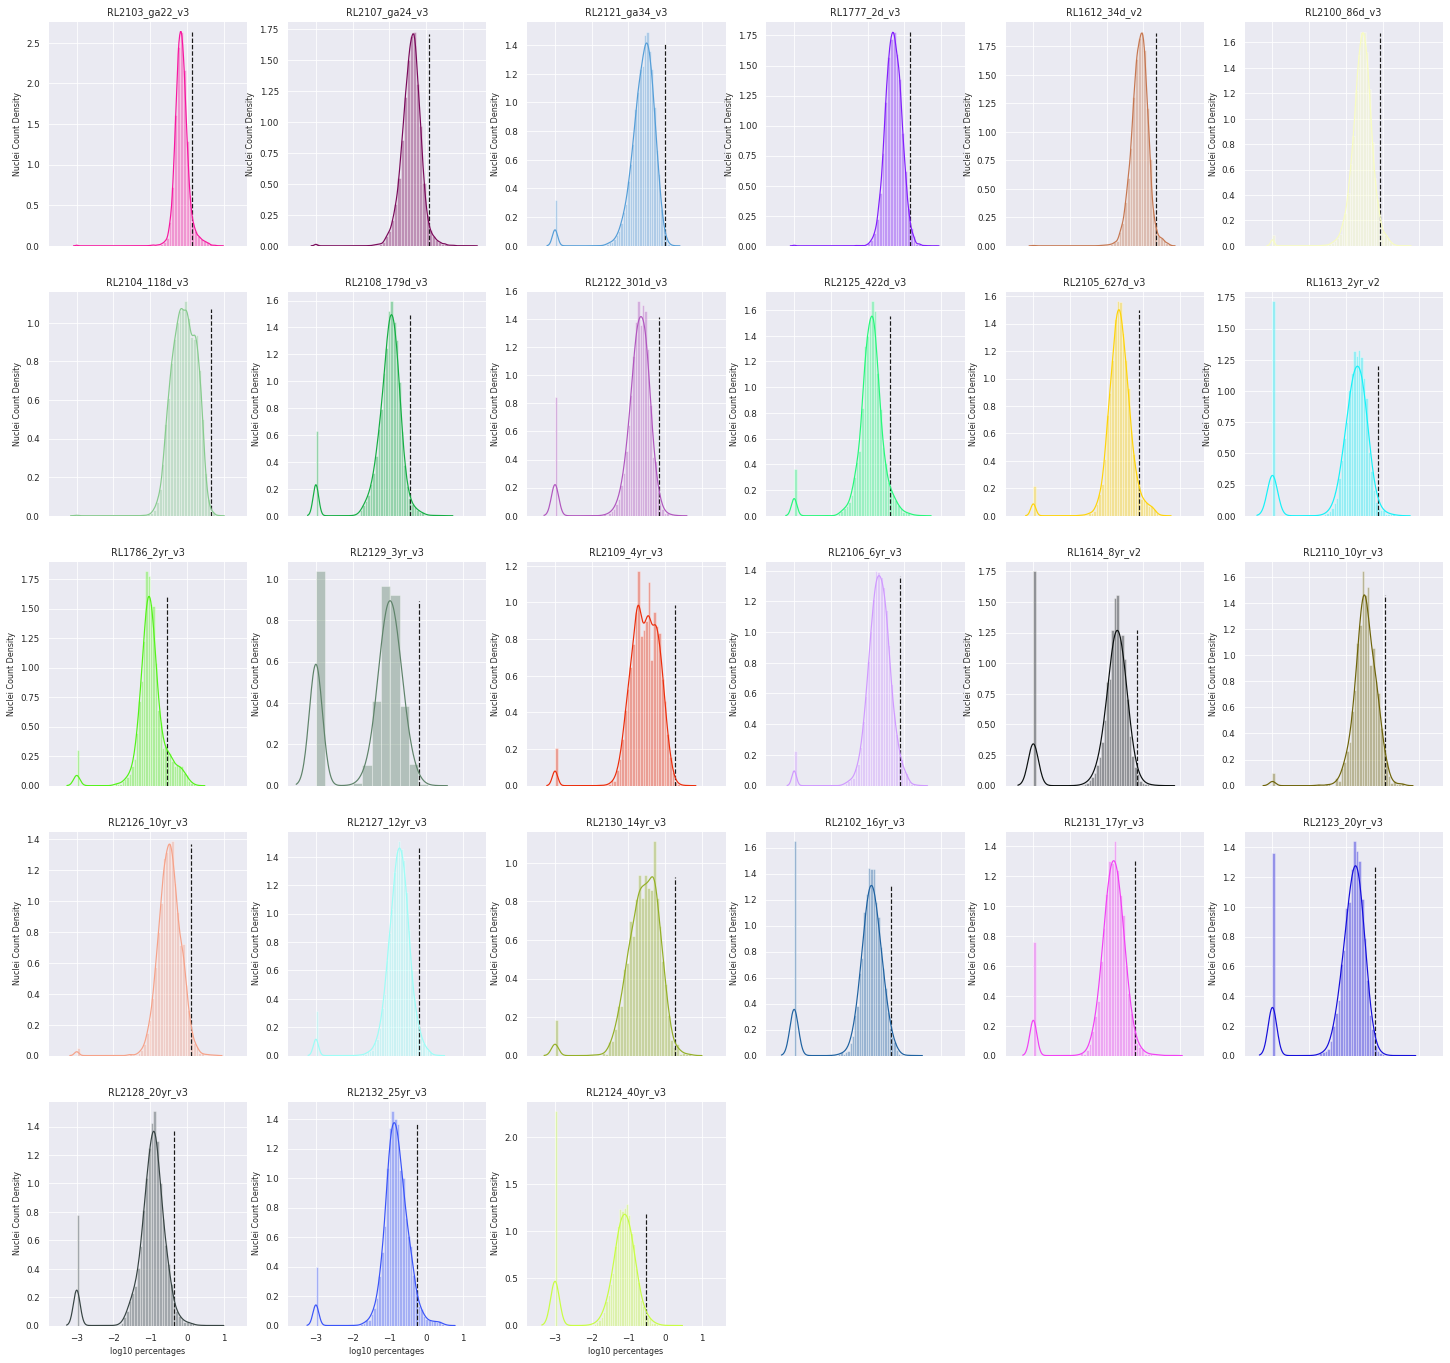

In [25]:
# remove all nuc with more than 3 MADs percentage ribo gene counts
ribo_per_mk = gene_set_MAD_plot_and_mask( adata, ribo_mk, 20.0)

In [26]:
combined_mk = (ribo_per_mk + mito_per_mk)
adata = mask_cells( adata, ~combined_mk)

Number of removed nuclei per sample:
RL1777_2d_v3      863
RL2103_ga22_v3    809
RL2107_ga24_v3    775
RL2122_301d_v3    734
RL2106_6yr_v3     708
RL2132_25yr_v3    602
RL2108_179d_v3    573
RL2128_20yr_v3    569
RL2100_86d_v3     546
RL1612_34d_v2     532
RL2125_422d_v3    489
RL2124_40yr_v3    428
RL2105_627d_v3    418
RL2131_17yr_v3    414
RL2104_118d_v3    383
RL2127_12yr_v3    370
RL1786_2yr_v3     369
RL2102_16yr_v3    356
RL2126_10yr_v3    252
RL2129_3yr_v3     232
RL2121_ga34_v3    228
RL2123_20yr_v3    193
RL1613_2yr_v2     186
RL2130_14yr_v3    139
RL2109_4yr_v3      68
RL1614_8yr_v2      66
RL2110_10yr_v3     63
Total removed =  11365


### Remove mito and ribo genes

In [27]:
adata = adata[:,~np.in1d( adata.var_names, np.append( mito_genes, ribo_genes))]

### Remove overly expressed genes before normalization.

MALAT1 is known to be overexpressed and can affect normalization. Highly expressed genes also have a large variance, so normal flucuations can have an outsized effect on library normalization. 

In [28]:
adata = adata[:,adata.var_names!='MALAT1']

Plot genes with highest percentage of counts for each sample

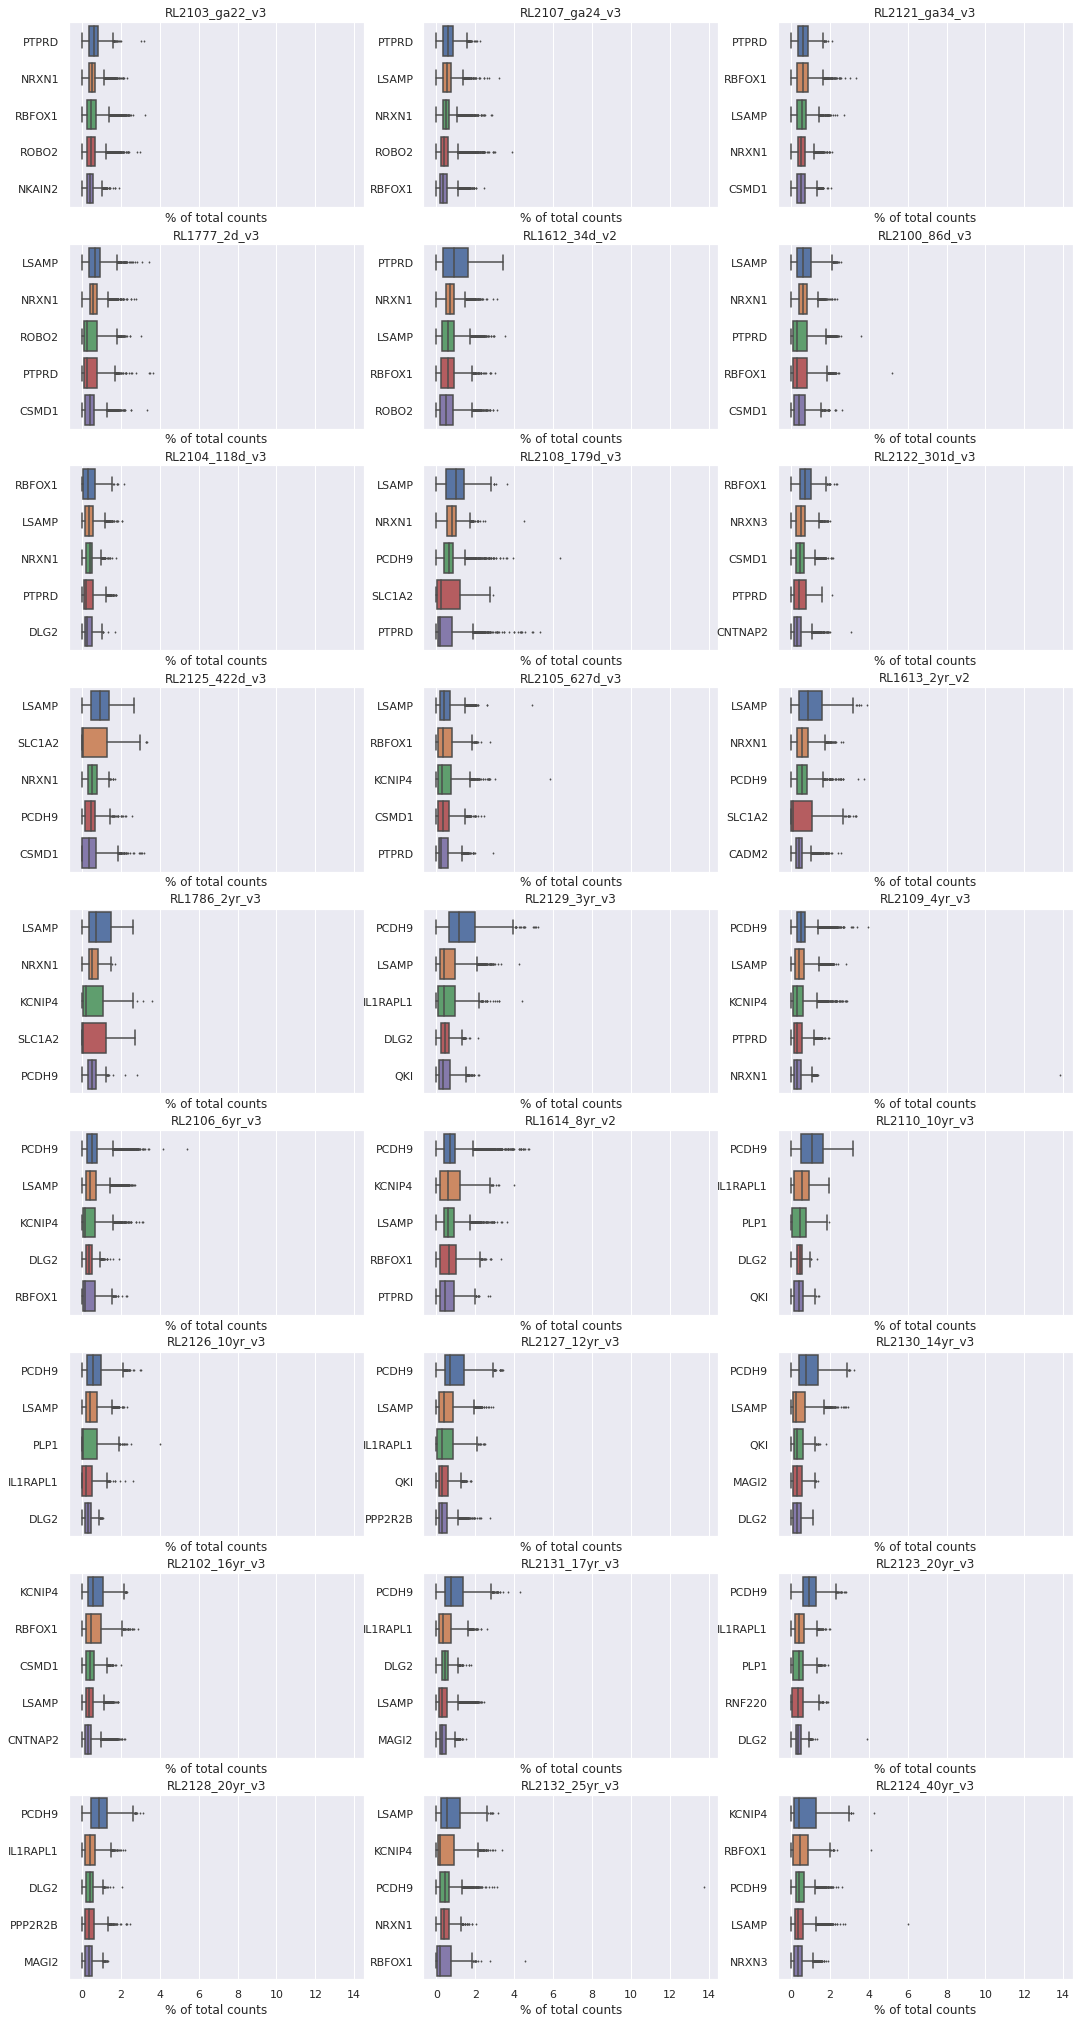

In [29]:
# plot highly expressed genes for each sample
sns.set()
n = len( adata.uns['batch_order'])
fig, axes = plt.subplots( math.ceil( n/3), 3, figsize=( 18, math.ceil( n/3)*4), sharex=True)
# loop through each sample
for itr, (bat_itr, ax) in enumerate( zip( adata.uns['batch_order'], axes.flatten())):
    bat_mk = adata.obs['batch']==bat_itr
    bat_adata = adata[bat_mk,:].copy()
    plt.sca(ax)
    sc.pl.highest_expr_genes( bat_adata, n_top=5, ax=ax, show=False)
    plt.title( bat_itr)

After removing mito, ribo, and MALAT1, nothing appears to be overly expressed at levels potentially problematic for library corrrections.

In [30]:
adata.shape

(175954, 29030)

# **Save cleaned anndata object**

In [31]:
out_file_nm = f"{data_path}cleaned_count_matrices.h5ad"
adata.write( out_file_nm)